<a href="https://colab.research.google.com/github/jk673/grapinnformer-clean/blob/main/test_gnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and modules

In [1]:
import torch, os, sys, subprocess

def in_colab():
    try:
        import google.colab  # Colab 전용 모듈
        return True
    except ImportError:
        return False

# 버전 및 wheel URL 구성
torch_ver = torch.__version__.split('+')[0]           # e.g. '2.8.0'
cuda_ver  = torch.version.cuda or ''
cu_tag    = f"cu{cuda_ver.replace('.','')}" if torch.cuda.is_available() and cuda_ver else "cpu"
url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cu_tag}.html"

print("Torch:", torch.__version__, "| CUDA:", cuda_ver or "cpu", "| PYG wheel index:", url)

# 설치
if in_colab():
    !pip install pyvista
    !pip install torch_geometric
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", "-U",
        "pyg-lib", "torch-scatter", "torch-sparse", "torch-cluster", "torch-spline-conv",
        "-f", url
    ])

print("✅ Done. Please restart runtime/kernel, then re-run your code.")


Torch: 2.8.0+cu126 | CUDA: 12.6 | PYG wheel index: https://data.pyg.org/whl/torch-2.8.0+cu126.html
✅ Done. Please restart runtime/kernel, then re-run your code.


In [2]:
# 1. Environment & dependencies
import gc
import glob
import math
import os
import random
import sys
import time
from itertools import chain
from os import PathLike
from pathlib import Path
from typing import List, Tuple, Union

import numpy as np
import pyvista as pv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor
import torch_geometric
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GCNConv, GraphNorm, JumpingKnowledge, TransformerConv
from tqdm.auto import tqdm
import wandb
import pyg_lib

# Data and model settings
DATA_ROOT = Path('data')
TARGET_FIELD = 'static(p)_coeffMean'
USE_NORMALS = True

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("pyg-lib ok;", getattr(pyg_lib, "__version__", "ok"))
print('Torch:', torch.__version__)
print('CUDA:', torch.version.cuda)
print('PyVista:', pv.__version__)
print('PyG:', torch_geometric.__version__ if 'torch_geometric' in sys.modules else 'unknown')
print("py  :", sys.version.split()[0])  # ex) 3.11.x

pyg-lib ok; 0.4.0+pt28cu126
Torch: 2.8.0+cu126
CUDA: 12.6
PyVista: 0.46.1
PyG: 2.6.1
py  : 3.12.11


# Utilities

In [3]:
from os import PathLike
from typing import Union, List
from torch import Tensor

AnyPath = Union[str, bytes, PathLike]

In [4]:
def _bar(total, desc, position, leave):
    return tqdm(total=total, desc=desc, position=position, leave=leave, **_TQDM_KW)


def _mkbar(total, desc, position=0, leave=False, progress=True):
    if not progress:
        return None  # 진행바 비활성화
    return tqdm(
        total=total, desc=desc, position=position, leave=leave,
        ncols=100, dynamic_ncols=False, mininterval=0.25, smoothing=0.1,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt} {postfix}"
    )

def _update(bar, n=1, postfix=None):
    if bar is None: return
    if postfix is not None:
        if isinstance(postfix, dict): bar.set_postfix(postfix)
        else: bar.set_postfix_str(str(postfix))
    bar.update(n)

def _close(bar):
    if bar is not None: bar.close()

def load_indices_packed(save_path: AnyPath, *, progress=True, position=3) -> List[Tensor]:
    obj = torch.load(save_path, map_location='cpu')
    ptr, nodes = obj["ptr"], obj["nodes"]
    out: List[Tensor] = []
    bar = _mkbar(ptr.numel()-1, "[cache] load patches", position=position, leave=False, progress=progress)
    for i in range(ptr.numel()-1):
        lo, hi = ptr[i].item(), ptr[i+1].item()
        out.append(nodes[lo:hi].clone())
        _update(bar, 1)
    _close(bar)
    return out


def fast_make_subgraph_pure(g: Data, node_idx: Tensor) -> Data:
    node_idx = node_idx.unique()
    mask = torch.zeros(g.num_nodes, dtype=torch.bool)
    mask[node_idx] = True

    ei = g.edge_index
    e_mask = mask[ei[0]] & mask[ei[1]]
    sub_edge = ei[:, e_mask]

    new_id = torch.full((g.num_nodes,), -1, dtype=torch.long)
    new_id[mask] = torch.arange(mask.sum(), dtype=torch.long)
    sub_edge = new_id[sub_edge]

    sub = Data()
    # 원본 E(엣지 수)
    E = ei.size(1)

    for k, v in g.items():
        if k == "edge_index":
            sub.edge_index = sub_edge
            continue

        if torch.is_tensor(v):
            # 1) node-level: [N, ...]
            if v.size(0) == g.num_nodes:
                sub[k] = v[mask]
                continue
            # 2) edge-level: [E, ...]
            if v.size(0) == E:
                sub[k] = v[e_mask]
                continue
            # 3) graph-level scalar/벡터 (크기 1 또는 배치 없음)
            if v.numel() == v.shape[0] and v.shape[0] == 1:
                sub[k] = v
                continue
            # 4) 그 외(예: y_graph 같은 그래프 레벨 텐서)
            #   - shape이 [G, ...]로 오면 그대로 둡니다(단일 그래프 가정).
            sub[k] = v
        else:
            sub[k] = v

    return sub

# Model

In [5]:
import torch
import torch.nn as nn

def ensure_pos_from_batch(batch, in_ch=3):
    """Return a [N, in_ch] pos tensor. Falls back to x[:, :in_ch] if .pos is missing."""
    pos = getattr(batch, "pos", None)
    if pos is None:
        x = getattr(batch, "x", None)
        assert x is not None and x.size(1) >= in_ch, \
            f"Need batch.pos or first {in_ch} columns in batch.x"
        pos = x[:, :in_ch]
    return pos

class FourierPosEnc(nn.Module):
    """
    Vectorized Fourier features: concat_{k=0..F-1} [sin(2^k pi * pos), cos(2^k pi * pos)]
    Output shape: [N, in_ch * 2 * num_frequencies]
    """
    def __init__(self, in_ch=3, num_frequencies=2, base=2.0):
        super().__init__()
        freqs = (base ** torch.arange(num_frequencies, dtype=torch.float32)) * torch.pi
        # stays on the right device via register_buffer
        self.register_buffer("freqs", freqs, persistent=False)
        self.in_ch = in_ch
        self.num_frequencies = num_frequencies
        self.out_dim = in_ch * (2 * num_frequencies)

    def forward(self, pos: torch.Tensor) -> torch.Tensor:
        # pos: [N, in_ch]
        assert pos.dim() == 2 and pos.size(1) >= self.in_ch
        pos = pos[:, :self.in_ch]

        # AMP-friendly: do trig in fp32 for stability, then cast back
        orig_dtype = pos.dtype
        pos32 = pos.to(torch.float32)

        # Broadcast: [N, in_ch, 1] * [F] -> [N, in_ch, F]
        ang = pos32.unsqueeze(-1) * self.freqs.view(1, 1, -1)

        pe = torch.cat([torch.sin(ang), torch.cos(ang)], dim=1)   # [N, 2*in_ch, F]
        pe = pe.flatten(1)                                        # [N, 2*in_ch*F]
        return pe.to(dtype=orig_dtype)


class FiLM(nn.Module):
    def __init__(self, cond_dim, hidden):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(cond_dim, hidden*2), nn.GELU(), nn.Linear(hidden*2, hidden*2)
        )
    def forward(self, h, cond):
        if cond is None: return h
        if cond.dim()==1: cond = cond.unsqueeze(0)
        gamma, beta = torch.chunk(self.mlp(cond), 2, dim=-1)
        return h * (1 + gamma.squeeze(0)) + beta.squeeze(0)

class BoundaryGraphNet(nn.Module):
    def __init__(self, in_dim, hidden=96, layers=4, dropout=0.15,   # ★ 192→96, 6→4
                 heads=2, use_pos_enc=True, pos_freqs=2, cond_dim=4, # ★ 4→2
                 out_dim_p=1, out_dim_tau=3, jk_mode='last', use_checkpoint=False,
                 predict_tau=False):
        super().__init__()
        self.use_pos_enc = use_pos_enc
        if use_pos_enc:
            self.pos_enc = FourierPosEnc(3, pos_freqs) if use_pos_enc else None
            in_dim = in_dim + self.pos_enc.out_dim

        self.predict_tau = predict_tau
        pe_dim = self.pos_enc.out_dim if use_pos_enc else 0

        self.x_enc = nn.Sequential(
            nn.Linear(in_dim + pe_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden)
        )

        # ★ edge_dim을 8로 크게 축소
        self.edge_encoder = nn.Sequential(
            nn.Linear(4, 16), nn.GELU(), nn.Linear(16, 8)
        )
        self.edge_dim = 8

        self.layers = nn.ModuleList()
        self.norms  = nn.ModuleList()
        for _ in range(layers):
            # ★ concat=False, out_channels=hidden, add_self_loops=False
            self.layers.append(TransformerConv(
                in_channels=hidden,
                out_channels=hidden,
                heads=heads,
                concat=False,
                dropout=dropout,
                edge_dim=self.edge_dim,
                beta=True,
            ))
            self.norms.append(GraphNorm(hidden))

        # ★ JK를 'last'로 기본 설정(메모리 절약). 필요시 'max'로 바꿔도 됨
        self.jk_mode = jk_mode
        if jk_mode == 'max':
            self.jk = JumpingKnowledge(mode='max')
        else:
            self.jk = None

        self.p_head   = nn.Sequential(nn.Linear(hidden, hidden), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden, out_dim_p))
        self.tau_head = nn.Sequential(nn.Linear(hidden, hidden), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden, out_dim_tau))

        self.film = FiLM(cond_dim, hidden) if cond_dim>0 else None
        self.dropout = dropout
        self.use_checkpoint = use_checkpoint  # ★ 필요할 때만 켜기

    @staticmethod
    def _make_edge_attr(pos, edge_index):
        i, j = edge_index
        rij = pos[j] - pos[i]
        dij = torch.norm(rij, dim=1, keepdim=True).clamp_min(1e-12)
        return torch.cat([rij, dij], dim=1)  # [E,4]

    def forward(self, data):
        x = data.x
        if self.use_pos_enc:
            pos = ensure_pos_from_batch(data)
            pe = self.pos_enc(pos)
            x = torch.cat([x, pe], dim=-1)

        else:
            pos = getattr(data, "pos", None)
            if pos is None:
                x = getattr(data, "x", None)
                if x is None or x.size(1) < 3:
                    raise ValueError("BoundaryGraphNet needs `pos` or `x[:,:3]`.")
                pos = x[:, :3]

        edge_index = data.edge_index
        pe = self.pos_enc(pos) if self.use_pos_enc else None
        h = self.x_enc(torch.cat([x, pe], dim=-1) if pe is not None else x)

        eattr = getattr(data, 'edge_attr', None)
        if eattr is None:
            eattr = self._make_edge_attr(pos, edge_index)
        e = self.edge_encoder(eattr)

        hs = [] if self.jk_mode == 'max' else None

        for conv, norm in zip(self.layers, self.norms):
            def block(h_in):
                h_mid = conv(h_in, edge_index, edge_attr=e)
                if self.film is not None and hasattr(data, 'global_cond'):
                    h_mid = self.film(h_mid, data.global_cond)
                h_mid = norm(h_mid)
                h_mid = F.gelu(h_mid)
                h_mid = F.dropout(h_mid, p=self.dropout, training=self.training)
                return h_mid

            h_res = h
            # ★ 선택적 체크포인팅(메모리↓, 연산↑)
            h = block(h) if not self.use_checkpoint else cp.checkpoint(block, h)
            h = h + h_res
            if hs is not None:
                hs.append(h)

        if self.jk_mode == 'max':
            h = self.jk(hs)
        # 'last'면 그냥 마지막 h 사용

        p_pred   = self.p_head(h)
        tau_pred = self.tau_head(h)
        return (p_pred, tau_pred) if self.predict_tau else p_pred


# Load data

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Colab Notebooks/CFD_Surrogate/graphs_slim.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
full_graph = torch.load(data_path, weights_only=False)

In [8]:
train_graphs, val_graphs = full_graph

# Data Loader

In [9]:
from pathlib import Path
from itertools import chain
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm  # Import tqdm for the progress bar

drive.mount('/content/drive', force_remount=True)

cache_path = '/content/drive/My Drive/Colab Notebooks/CFD_Surrogate/cache_bs60'
cache_train = '//'.join([cache_path, 'train'])
cache_val   = '//'.join([cache_path, 'val'])
BATCH_SIZE   = 60

# assumes you already have:
# - load_indices_packed(path) -> List[LongTensor]
# - fast_make_subgraph_pure(g, node_idx) -> Data

def build_loaders_from_cache(graphs, cache_root, batch_size=6, shuffle=True, num_workers=0):
    loaders = []
    for gid, g in enumerate(graphs):
        packed = Path(cache_root) / f"graph_{gid}" / "patch_indices.pth"
        assert packed.exists(), f"missing cache for graph {gid}: {packed}"
        patches = load_indices_packed(packed)  # list[LongTensor] (원본 그래프의 노드 인덱스)

        subgraphs = []
        for patch_idx in tqdm(patches, desc=f"Building subgraphs for graph {gid}", leave=False):
            # 1) 서브그래프 생성
            sub = fast_make_subgraph_pure(g, patch_idx)

            # 2) 원본 노드 인덱스 부착 (배치에서 concat되도록 LongTensor)
            if not torch.is_tensor(patch_idx):
                patch_idx = torch.as_tensor(patch_idx, dtype=torch.long)
            else:
                patch_idx = patch_idx.to(dtype=torch.long, non_blocking=False).contiguous()

            # 3) 길이 검증 (sub.num_nodes와 같아야 함)
            assert sub.num_nodes == patch_idx.numel(), \
                f"[gid={gid}] sub.num_nodes({sub.num_nodes}) != len(patch_idx)({patch_idx.numel()})"

            # 4) 부착
            sub.orig_idx = patch_idx  # ★ 핵심: 재조립에 사용

            subgraphs.append(sub)

        dl = DataLoader(subgraphs, batch_size=batch_size, shuffle=shuffle,
                        num_workers=num_workers, pin_memory=True)
        loaders.append(dl)

    len_epoch = sum(len(ld) for ld in loaders)
    return loaders, len_epoch


# usage
train_loaders, len_epoch = build_loaders_from_cache(train_graphs, cache_train, batch_size=BATCH_SIZE, num_workers=4)
val_loaders,   len_val   = build_loaders_from_cache(val_graphs,   cache_val,   batch_size=BATCH_SIZE, num_workers=4)

Mounted at /content/drive


[cache] load patches:   0%|                                                           | 0/494 ?it/s 

Building subgraphs for graph 0:   0%|          | 0/494 [00:00<?, ?it/s]

[cache] load patches:   0%|                                                           | 0/663 ?it/s 

Building subgraphs for graph 1:   0%|          | 0/663 [00:00<?, ?it/s]

[cache] load patches:   0%|                                                           | 0/651 ?it/s 

Building subgraphs for graph 2:   0%|          | 0/651 [00:00<?, ?it/s]

[cache] load patches:   0%|                                                           | 0/580 ?it/s 

Building subgraphs for graph 0:   0%|          | 0/580 [00:00<?, ?it/s]

In [10]:
from itertools import chain, islice

def summarize_loader_list(name, loaders, max_peek_batches=2):
    # 1) basic counts
    num_loaders = len(loaders)
    num_batches = sum(len(ld) for ld in loaders)
    num_items   = sum(len(getattr(ld, "dataset", [])) for ld in loaders)
    print(f"[{name}] #loaders={num_loaders}  #batches={num_batches}  #items={num_items}")
    assert num_batches > 0, f"[{name}] has zero batches (likely empty dataset or exhausted iterator)."

    # 2) peek a couple of batches
    it = chain(*(iter(ld) for ld in loaders))   # fresh iterator
    for i, b in enumerate(islice(it, max_peek_batches)):
        x_shape   = getattr(b, "x", None).shape if hasattr(b, "x") and b.x is not None else None
        ei_shape  = getattr(b, "edge_index", None).shape if hasattr(b, "edge_index") and b.edge_index is not None else None
        y_val     = getattr(b, "y", None)
        y_shape   = None if y_val is None else y_val.shape
        n_graphs  = getattr(b, "num_graphs", None)
        print(f"[{name} peek {i}] x={x_shape} edge_index={ei_shape} y={y_shape} num_graphs={n_graphs}")

        # extra guards
        assert ei_shape is not None and ei_shape[1] > 0, f"[{name} peek {i}] empty edge set"
        assert x_shape is not None and x_shape[0] > 0,    f"[{name} peek {i}] empty node set"

# ---- run for both train/val ----
summarize_loader_list("train", train_loaders)
summarize_loader_list("val",   val_loaders)


[train] #loaders=3  #batches=32  #items=1808
[train peek 0] x=torch.Size([184320, 8]) edge_index=torch.Size([2, 64226]) y=torch.Size([184320, 1]) num_graphs=60
[train peek 1] x=torch.Size([184320, 8]) edge_index=torch.Size([2, 63500]) y=torch.Size([184320, 1]) num_graphs=60
[val] #loaders=1  #batches=10  #items=580
[val peek 0] x=torch.Size([184320, 8]) edge_index=torch.Size([2, 63516]) y=torch.Size([184320, 1]) num_graphs=60
[val peek 1] x=torch.Size([184320, 8]) edge_index=torch.Size([2, 63528]) y=torch.Size([184320, 1]) num_graphs=60


# Training Loop

In [11]:
in_dim = 8
target_dim = 1
inferred_cond_dim = 2

# --------- 하이퍼파라미터 ---------
LR           = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS       = 1
PRINT_EVERY  = 5
GRAD_CLIP    = 5.0

# surface-only loss 가중치
LOSS_WEIGHTS = {"data": 1.0, "tv": 0.05, "lap": 0.01}
USE_TV = True
EPS = 1e-12

# --------- device ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


# --------- 모델 정의/이동 ----------
# ⚠️ out_dim을 타겟 채널 수로!
model = BoundaryGraphNet(
    in_dim=in_dim,
    hidden=256,
    layers=4,
    dropout=0.1,
    heads=2,
    use_pos_enc=True,
    pos_freqs=2,
    cond_dim=4   # 예: [Uinf, rho, nu, A_ref]를 data.global_cond로 넣을 때
).to(device)

# --------- optimizer (+옵션: 스케줄러) ----------
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=LR*0.1)

# --------- W&B init ----------
os.environ["WANDB_DISABLE_SYMLINKS"] = "true"  # <- wandb.init 이전에!

# wandb_run = wandb.init(
#     project="gnn-pinn-250819",     # <- 프로젝트명 바꿔도 됨
#     name=f"surface_only_{int(time.time())}",
#     config={
#         "epochs": EPOCHS,
#         "lr": LR,
#         "weight_decay": WEIGHT_DECAY,
#         "batch_size": BATCH_SIZE,
#         "grad_clip": GRAD_CLIP,
#         "loss_weights": LOSS_WEIGHTS,
#         "use_tv": USE_TV,
#         "feat_dim": in_dim,
#         "target_dim": target_dim,
#         "model": model.__class__.__name__,
#         "optimizer": "Adam",
#     },
# )

# --------- 기하 도우미/손실 ---------
def edge_geo_terms(pos: Tensor, edge_index: Tensor):
    i, j = edge_index
    e_ij   = pos[j] - pos[i]
    len_ij = e_ij.norm(dim=1, keepdim=True).clamp_min(torch.finfo(pos.dtype).tiny)
    t_ij   = e_ij / len_ij
    return i, j, t_ij, len_ij

def graph_edge_weights(pos: Tensor, edge_index: Tensor, mode="invlen", clamp=10.0):
    _, _, _, len_ij = edge_geo_terms(pos, edge_index)
    if mode == "invlen":
        w = (1.0 / (len_ij + EPS)).squeeze(1)
        if clamp is not None:
            w = w.clamp_max(clamp)
        return w
    else:
        return torch.ones(edge_index.size(1), device=pos.device, dtype=pos.dtype)

def edge_tv_or_l2(y_pred: Tensor, edge_index: Tensor, edge_w: Tensor, use_tv=True):
    i, j = edge_index
    diff = y_pred[i] - y_pred[j]  # (E,C)
    if use_tv:
        return (diff.abs() * edge_w.unsqueeze(-1)).mean()
    else:
        return ((diff**2) * edge_w.unsqueeze(-1)).mean()

def laplacian_reg(y_pred, edge_index, num_nodes, edge_w=None, eps=1e-12):
    """
    y_pred: [N, C]
    edge_index: [2, E] (long)
    edge_w: [E] or None
    """
    # --- 준비: dtype/device 정렬 ---
    device = y_pred.device
    dtype  = torch.float32  # 라플라시안은 fp32로 계산 권장
    # (원래 y_pred가 fp16/ bf16여도 여기선 fp32로 올려 계산 후 다시 캐스팅)

    # 인덱스는 long, 같은 디바이스
    i, j = edge_index
    i = i.to(device=device, dtype=torch.long)
    j = j.to(device=device, dtype=torch.long)

    E = i.numel()
    C = y_pred.size(1)

    # 엣지 가중치
    if edge_w is None:
        edge_w = torch.ones(E, device=device, dtype=dtype)
    else:
        edge_w = edge_w.to(device=device, dtype=dtype)

    # y를 fp32로
    y = y_pred.to(dtype)

    # --- degree 및 가중합 ---
    deg = torch.zeros(num_nodes, device=device, dtype=dtype)
    deg.scatter_add_(0, i, edge_w)  # deg[u] = sum_v w_uv

    wyj = torch.zeros((num_nodes, C), device=device, dtype=dtype)
    wyj.scatter_add_(0, i.unsqueeze(-1).expand(-1, C),
                     (edge_w.unsqueeze(-1) * y[j]))

    # 라플라시안 L y = D y - W y  (여기선 행 정규화/대칭 정규화 없이 단순형)
    Ly = deg.unsqueeze(-1) * y - wyj

    # 규제값: ||Ly||^2 (노드/채널 평균)
    reg = (Ly.pow(2).sum(dim=1)).mean()

    # 원래 dtype으로 캐스팅해서 리턴
    return reg.to(y_pred.dtype)


def surface_only_loss(batch, pred: Tensor, loss_weights=LOSS_WEIGHTS):
    x = batch.x
    y = batch.y
    edge_index = batch.edge_index
    pos = batch.pos if hasattr(batch, 'pos') and batch.pos is not None else x[:, :3]

    data_loss = nn.functional.mse_loss(pred, y)
    w_e = graph_edge_weights(pos, edge_index, mode="invlen")

    tv_loss  = edge_tv_or_l2(pred, edge_index, w_e, use_tv=USE_TV)

    if hasattr(batch, 'batch') and batch.batch is not None:
        lap_loss_acc = 0.0
        uniq = batch.batch.unique()
        for g_id in uniq:
            mask = (batch.batch == g_id)
            node_idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
            mask_i = mask[edge_index[0]]
            mask_j = mask[edge_index[1]]
            e_mask = mask_i & mask_j
            if e_mask.sum() == 0:
                continue
            sub_e = edge_index[:, e_mask]
            old2new = -torch.ones(mask.size(0), device=mask.device, dtype=torch.long)
            old2new[node_idx] = torch.arange(node_idx.size(0), device=mask.device)
            sub_e = old2new[sub_e]
            lap_loss_acc = lap_loss_acc + laplacian_reg(pred[mask], sub_e, node_idx.size(0), w_e[e_mask])
        lap_loss = lap_loss_acc / (uniq.numel() + EPS)
    else:
        lap_loss = laplacian_reg(pred, edge_index, x.size(0), w_e)

    loss = (loss_weights["data"] * data_loss +
            loss_weights["tv"]   * tv_loss  +
            loss_weights["lap"]  * lap_loss)

    return loss, {"loss_data": data_loss.detach(),
                  "loss_tv":   tv_loss.detach(),
                  "loss_lap":  lap_loss.detach()}

# ======================
# Training / Validation
# ======================
best_val = float('inf')
best_path = "best_surface_only.pt"
torch.cuda.empty_cache()

for epoch in range(1, EPOCHS + 1):
    train_iter = chain(*(iter(ld) for ld in train_loaders))

    model.train()
    tr_loss_sum = 0.0; tr_nodes = 0
    ep_data = ep_tv = ep_lap = 0.0
    scaler = torch.cuda.amp.GradScaler(enabled=True)

    for step, batch in enumerate(train_iter, 1):
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)


        with torch.cuda.amp.autocast(enabled=True):
            pred = model(batch)
            if pred.dim() == 1:
                pred = pred.unsqueeze(1)
            loss, parts = surface_only_loss(batch, pred)


        # ★ 올바른 순서: backward -> unscale -> clip -> step -> update
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if GRAD_CLIP and GRAD_CLIP > 0:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        # ★ CosineAnnealingWarmRestarts는 iteration 단위 step이 자연스러움
        scheduler.step(epoch - 1 + step / len_epoch)

        n = batch.x.size(0)
        tr_loss_sum += loss.item() * n
        tr_nodes    += n
        ep_data += parts["loss_data"].item() * n
        ep_tv   += parts["loss_tv"].item()   * n
        ep_lap  += parts["loss_lap"].item()  * n

    train_loss = tr_loss_sum / max(tr_nodes, 1)
    train_data = ep_data / max(tr_nodes, 1)
    train_tv   = ep_tv   / max(tr_nodes, 1)
    train_lap  = ep_lap  / max(tr_nodes, 1)

    # -------- Validation --------
    model.eval()
    va_loss_sum = 0.0
    va_nodes    = 0
    va_data, va_tv, va_lap = 0.0, 0.0, 0.0

    val_iter = chain(*(iter(ld) for ld in val_loaders))
    with torch.no_grad():
        for batch in val_iter:
            batch = batch.to(device, non_blocking=True)
            pred = model(batch)
            if pred.dim() == 1:
                pred = pred.unsqueeze(1)
            v_loss, v_parts = surface_only_loss(batch, pred)

            n = batch.x.size(0)
            data_loss = v_parts["loss_data"]           # 데이터 MSE만 사용
            va_loss_sum += data_loss.item() * n   # total 대신 data loss만 누적
            va_nodes    += n

            va_data += v_parts["loss_data"].item() * n
            va_tv   += v_parts["loss_tv"].item()   * n
            va_lap  += v_parts["loss_lap"].item()  * n

    val_loss = va_loss_sum / max(va_nodes, 1)
    val_data = va_data / max(va_nodes, 1)
    val_tv   = va_tv   / max(va_nodes, 1)
    val_lap  = va_lap  / max(va_nodes, 1)

    # -------- W&B logging --------
    current_lr = optimizer.param_groups[0]["lr"]
    # wandb.log({
    #     "epoch": epoch,
    #     "lr": current_lr,
    #     "train/loss": train_loss,
    #     "train/loss_data": train_data,
    #     "train/loss_tv": train_tv,
    #     "train/loss_lap": train_lap,
    #     "val/loss": val_loss,
    #     "val/loss_data": val_data,
    #     "val/loss_tv": val_tv,
    #     "val/loss_lap": val_lap,
    # })

    if epoch % PRINT_EVERY == 0 or epoch == 1:

        print(f"[{epoch:03d}] train {train_loss:.6f} | val {val_loss:.6f} | lr {current_lr:.2e}")

        # -------- best model 저장 & W&B 업로드 --------
        if val_loss < best_val:
            best_val = val_loss
            torch.save({"model": model.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "epoch": epoch,
                         "val_loss": best_val}, best_path)
            # "config": wandb.config}, best_path)
            # 파일을 W&B에 첨부 (Artifacts가 필요 없으면 이걸로 충분)
            # artifact = wandb.Artifact(
            # name="best_model",
            # type="model",
            # metadata={"val_loss": float(best_val)}
            # )
            # artifact.add_file(best_path, name="best_surface_only.pt")
            # wandb.log_artifact(artifact)  # <- 이 한 줄이면 끝

        # run 종료
        # wandb.finish()


Device: cuda
[001] train 0.214873 | val 0.036450 | lr 9.78e-05


# Validation/Visualization

In [45]:
# ---- Drop-in fixes (put above plot_gt_vs_pred_iso) ----
import numpy as np
import matplotlib.tri as mtri

def _to_np(x):
    import torch
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def ensure_pos3(pos):
    """
    Coerce positions to shape [N,3].
    Accepts:
      - [N,3]
      - [3,N]  (will transpose)
      - flat length 3N (will reshape)
    """
    P = _to_np(pos)
    if P.ndim == 1:
        if P.size % 3 != 0:
            raise ValueError(f"pos is 1D of len {P.size}, not divisible by 3")
        P = P.reshape(-1, 3)
    elif P.ndim == 2:
        if P.shape[1] == 3:
            pass
        elif P.shape[0] == 3:
            P = P.T
        else:
            raise ValueError(f"pos has shape {P.shape}, expected [N,3] or [3,N]")
    else:
        raise ValueError(f"pos has ndim={P.ndim}, expected 1 or 2")
    return P.astype(np.float32)

def iso_project(pos_xyz, deg_z: float = 45.0, deg_x: float = 35.26438968):
    P = ensure_pos3(pos_xyz)  # <-- robust shape handling
    rz = np.deg2rad(deg_z); rx = np.deg2rad(deg_x)
    cz, sz = np.cos(rz), np.sin(rz)
    cx, sx = np.cos(rx), np.sin(rx)
    Rz = np.array([[cz,-sz,0],[sz,cz,0],[0,0,1]], dtype=np.float32)
    Rx = np.array([[1,0,0],[0,cx,-sx],[0,sx,cx]], dtype=np.float32)
    PR = P @ Rz.T @ Rx.T
    return PR[:, :2]

def ensure_faces_tris(faces):
    """
    Accepts:
      - [M,3] triangles
      - [3,M] triangles (PyG Mesh style) -> will transpose
      - None -> returns None
    """
    if faces is None:
        return None
    F = _to_np(faces)
    if F.ndim != 2:
        raise ValueError(f"faces ndim={F.ndim}, expected 2")
    if F.shape[1] == 3:   # [M,3]
        return F.astype(np.int64)
    if F.shape[0] == 3:   # [3,M]
        return F.T.astype(np.int64)
    raise ValueError(f"faces has shape {F.shape}, expected [M,3] or [3,M]")

def _shape_debug(pos, gt, pred, faces=None, label="(val)"):
    P = _to_np(pos)
    G = _to_np(gt)
    R = _to_np(pred)
    print(f"[debug{label}] pos shape: {getattr(P,'shape',None)}  gt: {G.shape}  pred: {R.shape}"
          + (f"  faces: {getattr(faces,'shape',None)}" if faces is not None else ""))



def iso_project(pos_xyz, deg_z: float = 45.0, deg_x: float = 35.26438968):
    """
    Isometric projection: rotate around Z, then around X, then drop Z.
    pos_xyz: array-like [N,3] (torch.Tensor or np.ndarray)
    returns: np.ndarray [N,2]
    """
    if _HAS_TORCH and isinstance(pos_xyz, torch.Tensor):
        P = pos_xyz.detach().cpu().numpy()
    else:
        P = np.asarray(pos_xyz)
    assert P.shape[1] >= 3, "pos must have at least 3 columns (x,y,z)."
    P = P[:, :3].astype(np.float32)

    rz = np.deg2rad(deg_z)
    rx = np.deg2rad(deg_x)
    cz, sz = np.cos(rz), np.sin(rz)
    cx, sx = np.cos(rx), np.sin(rx)

    Rz = np.array([[cz, -sz, 0.0],
                   [sz,  cz, 0.0],
                   [0.0, 0.0, 1.0]], dtype=np.float32)
    Rx = np.array([[1.0, 0.0, 0.0],
                   [0.0,  cx, -sx],
                   [0.0,  sx,  cx]], dtype=np.float32)

    PR = P @ Rz.T @ Rx.T
    return PR[:, :2]  # drop Z

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from tqdm.auto import tqdm

def plot_gt_vs_pred_iso(
    pos, gt, pred, faces=None, levels=60, title_var="Scalar",
    deg_z: float = 45.0, deg_x: float = 35.26438968, save_path=None,
    vmin=None, vmax=None, mask_circle_ratio: float = 0.03,
    apply_edge_length_mask: bool = True, edge_prct_cut: float = 95.0,
    show_progress: bool = True
):
    """
    Same as before (A method), but with a compact progress bar that ticks through:
    1) projection, 2) triangulation, 3) flat-mask, 4) edge-mask, 5) draw GT, 6) draw Pred, 7) finalize
    """
    try:
        import torch
        _HAS_TORCH = True
    except Exception:
        _HAS_TORCH = False

    def _to_np_1d(x):
        if _HAS_TORCH and isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        x = np.asarray(x)
        return x.reshape(-1)

    def _ensure_faces_tris(f):
        if f is None:
            return None
        import torch as _torch
        if isinstance(f, _torch.Tensor):
            if f.numel() == 0:
                return None
            F = f.detach().cpu().numpy()
        else:
            F = np.asarray(f)
        if F.ndim != 2:
            return None
        if F.shape[0] == 3 and F.shape[1] >= 1:
            F = F.T
        if F.shape[1] != 3:
            return None
        return F.astype(np.int64)

    steps = [
        "Iso project", "Triangulation", "Mask (flat)", "Mask (edge-length)",
        "Draw GT", "Draw Pred", "Finalize"
    ]
    pbar = tqdm(total=len(steps), disable=not show_progress, desc="Plot iso")

    # 1) projection
    pos2d = iso_project(pos, deg_z=deg_z, deg_x=deg_x)
    gt_np = _to_np_1d(gt)
    pr_np = _to_np_1d(pred)
    pbar.update(1)  # Iso project

    # color scale
    if vmin is None or vmax is None:
        allv = np.concatenate([gt_np, pr_np])
        vmin = np.percentile(allv, 1) if vmin is None else vmin
        vmax = np.percentile(allv, 99) if vmax is None else vmax

    # 2) triangulation
    faces_safe = _ensure_faces_tris(faces)
    if faces_safe is not None:
        tri = mtri.Triangulation(pos2d[:, 0], pos2d[:, 1], triangles=faces_safe)
    else:
        tri = mtri.Triangulation(pos2d[:, 0], pos2d[:, 1])
    pbar.update(1)  # Triangulation

    # 3) flat tri mask
    try:
        ta = mtri.TriAnalyzer(tri)
        mask_flat = ta.get_flat_tri_mask(min_circle_ratio=mask_circle_ratio)
        tri.set_mask(mask_flat)
    except Exception:
        pass
    pbar.update(1)  # Mask (flat)

    # 4) edge-length mask
    if apply_edge_length_mask and tri.triangles is not None:
        xy = pos2d
        T = tri.triangles
        def edge_len(a, b):
            d = xy[a] - xy[b]
            return np.sqrt((d*d).sum(axis=1))
        Lmax = np.stack([
            edge_len(T[:, 0], T[:, 1]),
            edge_len(T[:, 1], T[:, 2]),
            edge_len(T[:, 2], T[:, 0]),
        ], axis=1).max(axis=1)
        thr = np.percentile(Lmax, edge_prct_cut)
        mask_len = Lmax > thr
        tri.set_mask(mask_len if tri.mask is None else (tri.mask | mask_len))
    pbar.update(1)  # Mask (edge-length)

    # 5~6) draw panels with a small progress over 2 panes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=160, constrained_layout=True)
    last_pc = None
    for k, (ax, data, ttl) in enumerate(zip(axes, (gt_np, pr_np), ("Ground Truth", "Prediction")), start=1):
        last_pc = ax.tripcolor(tri, data, shading='gouraud', vmin=vmin, vmax=vmax, antialiased=False)
        ax.set_aspect("equal")
        ax.axis("off")
        ax.set_title(ttl, fontsize=12)
        pbar.update(1)  # Draw GT then Draw Pred

    cbar = fig.colorbar(last_pc, ax=axes.ravel().tolist(), fraction=0.035, pad=0.02)
    cbar.set_label(title_var, rotation=90)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")

    plt.show()
    pbar.update(1)  # Finalize
    pbar.close()


In [51]:
def _get_face_tensor_safe(G):
    """
    여러 가능성(face, faces, tri, triangles 등)을 탐색해서
    [M,3] LongTensor로 표준화하여 반환. 없으면 None.
    """
    import torch
    cand_names = ["face", "faces", "tri", "triangles", "mesh_faces", "mesh_face"]
    face = None
    for name in cand_names:
        if hasattr(G, name):
            face = getattr(G, name)
            break
    if face is None:
        return None
    # None일 수도 있음
    if face is None:
        return None
    # torch.Tensor or np.ndarray만 허용
    if isinstance(face, torch.Tensor):
        if face.numel() == 0:
            return None
        F = face
    else:
        import numpy as np
        F = torch.as_tensor(np.asarray(face))
        if F.numel() == 0:
            return None

    # [3, M] -> [M,3]
    if F.dim() == 2 and F.size(0) == 3:
        F = F.t().contiguous()
    # [M,3] 확인
    if F.dim() != 2 or F.size(1) != 3:
        return None
    return F.long()


In [52]:
from tqdm.auto import tqdm
import torch

@torch.no_grad()
def stitch_patch_predictions(
    model,
    val_loader,
    G_full,               # whole-graph Data (pos/x, y[, face])
    device="cuda",
    in_ch=3,
    show_progress=True
):
    model.eval()

    # pos via your helper (pos or x[:,:in_ch])
    pos_all = ensure_pos_from_batch(G_full, in_ch=in_ch)
    N = pos_all.size(0)

    pred_sum = torch.zeros(N, dtype=torch.float32)
    pred_cnt = torch.zeros(N, dtype=torch.int32)

    # best-effort total
    try:
        total_batches = len(val_loader)
    except TypeError:
        total_batches = None

    pbar = tqdm(val_loader, total=total_batches, disable=not show_progress, desc="Stitching patches")
    for batch in pbar:
        batch = batch.to(device)
        pred = model(batch)
        if pred.dim() > 1 and pred.size(-1) == 1:
            pred = pred.squeeze(-1)
        pred = pred.detach().cpu()

        # global indices on batch
        if hasattr(batch, "n_id"):
            g_idx = batch.n_id.detach().cpu().long()
        elif hasattr(batch, "orig_idx"):
            g_idx = batch.orig_idx.detach().cpu().long()
        elif hasattr(batch, "node_idx"):
            g_idx = batch.node_idx.detach().cpu().long()
        else:
            raise ValueError("Need global node indices on batch: one of n_id / orig_idx / node_idx")

        pred_sum[g_idx] += pred
        pred_cnt[g_idx] += 1

        if show_progress:
            covered_now = int((pred_cnt > 0).sum().item())
            pbar.set_postfix_str(f"covered nodes={covered_now}/{N}")

    pred_cnt_clamped = pred_cnt.clamp(min=1)
    pred_full = pred_sum / pred_cnt_clamped

    covered = pred_cnt > 0
    pos_full = pos_all[covered]

    # ground truth
    y_full = getattr(G_full, "y", None)
    if y_full is None:
        raise ValueError("G_full has no 'y'.")
    if y_full.dim() > 1 and y_full.size(-1) == 1:
        y_full = y_full.squeeze(-1)
    gt_full = y_full[covered]

    pred_cov = pred_full[covered]

    # faces (safe)
    faces_sub = None
    face_full = _get_face_tensor_safe(G_full)
    if face_full is not None:
        mask_idx = torch.nonzero(covered, as_tuple=False).view(-1)
        inv_map = -torch.ones(N, dtype=torch.long)
        inv_map[mask_idx] = torch.arange(mask_idx.numel(), dtype=torch.long)

        keep = covered[face_full[:, 0]] & covered[face_full[:, 1]] & covered[face_full[:, 2]]
        f_kept = face_full[keep]
        if f_kept.numel() > 0:
            faces_sub = inv_map[f_kept]

    return pos_full, gt_full, pred_cov, faces_sub


Stitching patches:   0%|          | 0/10 [00:00<?, ?it/s]

Plot iso (grid):   0%|          | 0/8 [00:00<?, ?it/s]

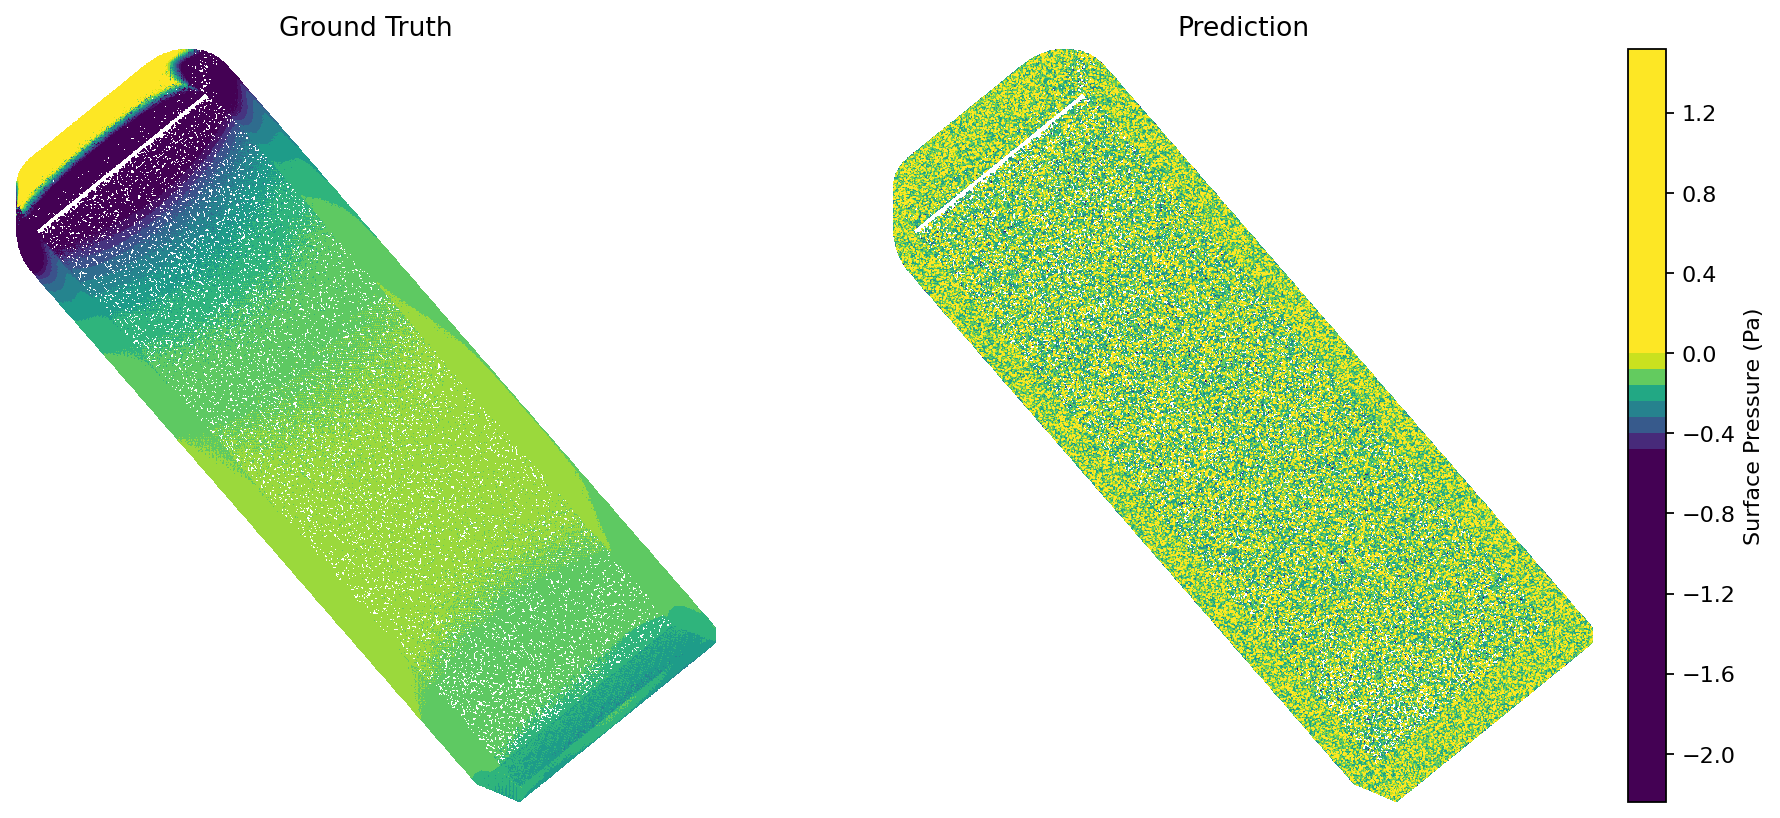

In [49]:
# 예시 실행
pos_full, gt_full, pred_full, faces_sub = stitch_patch_predictions(
    model=model,
    val_loader=val_loaders[0],   # 패치 기반 검증 로더
    G_full=val_graphs[0],        # 전체 그래프(Data). 필요에 맞게 선택
    device=device
)

plot_gt_vs_pred_iso(
    pos=pos_full, gt=gt_full, pred=pred_full,
    faces=faces_sub,                 # 있으면 훨씬 깔끔
    title_var="Surface Pressure (Pa)",
    deg_z=-50, deg_x=15,
    vmin=-0.5, vmax=0.0,
    mask_circle_ratio=0.03,
    apply_edge_length_mask=True, edge_prct_cut=95.0,
    save_path=None
)
